# Conversion to a different overdensity

This is done by iteratively integrating the profile and finding the radius enclosing a specified overdensity. Here we demonstrate it with the NFW profile but note that this method is available for all `profiley` profiles.

In [1]:
import profiley
profiley.__version__

'1.5.0'

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from profiley.nfw import NFW

As always, let's make the plots a little nicer:

In [3]:
from plottery.plotutils import update_rcParams
update_rcParams()

In [4]:
m200m = np.array([1e15])
c = np.array([4, 8])
z = np.linspace(0, 1, 3)[:,None]

In [5]:
nfw = NFW(m200m, c, z, overdensity=200, background='m')
nfw

NFW profile object containing 6 profiles
shape: (3, 2)
  overdensity: 200m
  log10 mass/Msun = 15.00
  concentration range = 4.00-8.00
  redshift range = 0.00-1.00

In the current implementation, we may have to tweak convergence parameters a little to achieve the desired precision. Future versions will have some built-in flexibility to minimize user interaction. Since `mdelta` calls `rdelta` to do the calculations, let's take a look at the docs for the latter:

In [6]:
help(nfw.rdelta)

Help on method rdelta in module profiley.core:

rdelta(overdensity: float, background: str, *, rtol: float = 0.001, trial_range: float = 0.1, trial_size: int = 20, max_trials: int = 100, log_rmin: float = -10, integral_samples: int = 1000, return_errors: bool = False) method of profiley.nfw.NFW instance
    Calculate the radius within which the density equals a specified overdensity
    
    Parameters
    ----------
    overdensity : float
        The desired overdensity
    background : 'c' or 'm'
        Whether to use the critical or mean density as a reference
    rtol : float, optional
        The relative tolerance for convergence. The default is 0.001
    trial_range : float, optional
        The fractional range to explore around the best radius in each iteration. Use a smaller number for smaller tolerances. The default is 0.1, corresponding to a 10% search in each iteration
    trial_size : int, optional
        The number of radii to try in each iteration. The default is 20


So let's change a few of the default parameters for the purpose of this demo:

In [7]:
%%time
m500c, r500c, density_errors = nfw.mdelta(500, 'c', rtol=0.01, return_errors=True)

CPU times: user 15 ms, sys: 5.04 ms, total: 20 ms
Wall time: 19.7 ms


The fact we didn't get a warning suggests all calculations converged:

In [8]:
np.all(density_errors < 0.01)

True

To verify that the calculation makes sense we can compare the profiles defined in both ways.

In [9]:
nfw_500c = NFW(m500c, r500c / nfw.rs, z, overdensity=500, background='c')
nfw_500c

NFW profile object containing 6 profiles
shape: (3, 2)
  overdensity: 500c
  log10 mass/Msun range = 14.56-14.86
  concentration range = 1.42-4.85
  redshift range = 0.00-1.00

Numbers are, of course, different, but the profiles should be exactly the same:

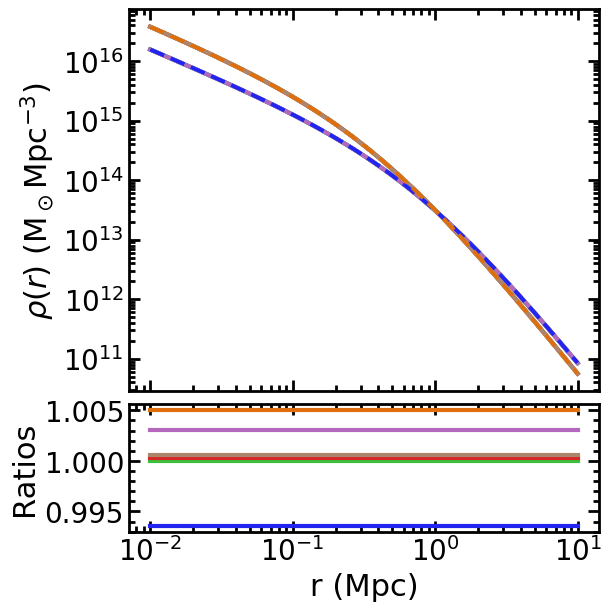

In [10]:
r = np.logspace(-2, 1, 100)
fig, axes = plt.subplots(2, 1, figsize=(6, 6), height_ratios=(3,1), sharex=True, constrained_layout=True)
axes[0].plot(r, nfw.profile(r).reshape(r.size, -1), ls='-', lw=3)
axes[0].plot(r, nfw_500c.profile(r).reshape(r.size, -1), ls='--', lw=3)
axes[0].set(xscale='log', yscale='log', ylabel='$\\rho(r)$ (M$_\\odot$Mpc$^{-3}$)')
axes[1].plot(r, (nfw_500c.profile(r)  / nfw.profile(r)).reshape(r.size, -1), ls='-', lw=3)
axes[1].set(xlabel='r (Mpc)', ylabel='Ratios');

Dashed lines are essentially exactly on top of solid lines. The bottom panel shows that by choosing a relative tolerance `rtol=0.01`, which is fairly easy to achieve, we've made errors on the density profile which are all well below 1%.